In [1]:
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.neighbors import KNeighborsRegressor

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

/anaconda3/envs/neuro/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data Preparation

In [6]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [7]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

In [8]:
# Reset scaling and transformation
temp = scaler_targets.inverse_transform(targets)
temp[:, 1:] = np.power(temp[:, 1:], 1./1.5)
df_target = pd.DataFrame(temp, columns=targets.columns)
df_target.head()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,57.436077,30.571975,62.553736,53.325130,51.427998
1,59.580851,50.969456,67.470628,60.651856,58.311361
2,71.413018,53.152498,58.012103,52.418389,62.536641
3,66.532630,NaN,NaN,52.108977,69.993075
4,38.617381,49.197021,65.674285,40.151376,34.096421


In [9]:
filenames = sorted(glob('results/results_tr*csv'))
labels = np.array([[r[19:].split('_')[0], '_'.join(r[19:].split('.')[0].split('_')[1:])[:'_'.join(r[19:].split('.')[0].split('_')[1:]).find('merge')+5]] for r in filenames])
labels

array([['baseline', 'merge'],
       ['nn-multi', 'merge'],
       ['nn-multi', 'short_merge'],
       ['nn-single', 'merge'],
       ['nn-single', 'short_merge'],
       ['ridge', 'age_merge'],
       ['ridge', 'age_short_merge'],
       ['ridge', 'merge'],
       ['ridge', 'short_merge'],
       ['sgd', 'age_merge'],
       ['sgd', 'age_short_merge'],
       ['sgd', 'merge'],
       ['sgd', 'short_merge'],
       ['svr-linear', 'age_merge'],
       ['svr-linear', 'age_short_merge'],
       ['svr-linear', 'merge'],
       ['svr-linear', 'short_merge'],
       ['svr-rbf', 'age_merge'],
       ['svr-rbf', 'age_short_merge'],
       ['svr-rbf', 'merge'],
       ['svr-rbf', 'short_merge']], dtype='<U15')

In [10]:
# Collect datasets
dataset = []
for i, f in enumerate(filenames):
    df_temp = pd.read_csv(f)
    df_temp['model'] = labels[i, 0]
    df_temp['dataset'] = labels[i, 1]
    dataset.append(df_temp)
df_data = pd.concat(dataset)

### Combine all predictions into one dataset

In [11]:
def get_data(tid = '_te'):
    filenames = sorted(glob('results/results%s*csv' % tid))
    labels = np.array([[r[19:].split('_')[0], '_'.join(r[19:].split('.')[0].split('_')[1:])[:'_'.join(r[19:].split('.')[0].split('_')[1:]).find('merge')+5]] for r in filenames])
    labels

    for i, f in enumerate(filenames):
        m, d = labels[i]

        df_temp = pd.read_csv(f)
        df_temp = df_temp.set_index('Id')
        df_temp.columns = ['%s_%s-%s' % (c, m, d) for c in df_temp.columns]

        if i ==0:
            df_res = df_temp.copy()
        else:
            df_res = pd.merge(df_res, df_temp, on='Id')

    return df_res.T.drop_duplicates().T

In [12]:
def load_dataset():

    # Load dataset
    X_tr = get_data(tid = '_tr')
    X_te = get_data(tid = '_te')

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y_tr = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')

    # Remove missing values
    idx = y_tr.index.isin(X_tr.index)
    y_tr = y_tr[idx].values

    # Reset scaling and transformation
    y_tr = scaler_targets.inverse_transform(y_tr)
    y_tr[:, 1:] = np.power(y_tr[:, 1:], 1./1.5)

    return X_tr, X_te, y_tr, idx

In [13]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0) / np.sum(y_true, axis=0))

In [14]:
def create_grid(model_metric, estimator=None, cv=5, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    ks = np.arange(1, 25)
    param_grid = [
    { 
        'scaler': [None],
        'pca': [None, PCA(0.99)],
        'estimator__n_neighbors': ks,
        'estimator__weights': ['uniform'],
        'estimator__p': [2],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [15]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    """
    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]
    """
    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [16]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [17]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__n_neighbors'].astype('int')
    df_pred['param_estimator__weights'] = df_pred['param_estimator__weights'].astype('str')
    df_pred['param_estimator__p'] = df_pred['param_estimator__p'].astype('int')
    
    return df_pred

In [18]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for w in df_pred['param_estimator__weights'].unique():
                for d in df_pred['param_estimator__p'].unique():

                    df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                               df_pred['param_scaler']==s,
                                               df_pred['param_estimator__weights']==w,
                                               df_pred['param_estimator__p']==d],
                                              axis=0).astype('bool')]
                    df_plot = df_plot.sort_values('param_estimator__alpha')

                    # Skip hyperparameter combination if not explored
                    if df_plot.shape[0] == 0:
                        continue

                    # Extract relevant modelling metrics
                    train_scores = df_plot['mean_train_score']
                    valid_scores = df_plot['mean_test_score']
                    std_tr = df_plot['std_train_score']
                    std_va = df_plot['std_test_score']

                    plt.figure(figsize=(12, 4))
                    alphas = df_plot['param_estimator__alpha']
                    plt.plot(alphas, train_scores, label='Training Set')
                    plt.plot(alphas, valid_scores, label='Validation Set')

                    # Add marker and text for best score
                    max_id = np.argmax(valid_scores)
                    x_pos = alphas.iloc[max_id]
                    y_pos = valid_scores.iloc[max_id]
                    txt = '{:0.4f}'.format(y_pos)
                    plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                    plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                    # Quantify variance with ±std curves
                    plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                    plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                    plt.ylabel('Performance metric')
                    plt.xlabel('Model parameter')

                    # Adjust x-lim, y-lim, add legend and adjust layout
                    plt.legend()
                    plt.title('%s\n%s\n%s\n%s' % (str(s), str(p), str(w), str(d)))
                    plt.show()

In [19]:
def run_prediction(model_metric, target='age', estimator=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset()
    y_tr = y_tr[:, tidx]
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [20]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:10])

In [21]:
def create_results_dataframe(predictions, targets, t_idx, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Store results in Dataframe
    df_results = pd.DataFrame(results, columns=targets.columns)

    """
    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]
    """

    # Add ID back to test results
    if res_type=='_tr':
        df_results.insert(0, 'Id', t_idx[predictions['age_miss']])
        df_results.set_index('Id', inplace=True)
    elif res_type=='_te':
        df_results.insert(0, 'Id', t_idx)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [22]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [23]:
def save_results(predictions, targets, train_id, test_id, sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, targets, train_id, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, targets, test_id, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/h_submission_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/h_results_tr_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/h_results_te_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [24]:
def plot_prediction_distributions(targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(targets, columns=targets.columns)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

Starting with target: age
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


Best: -0.063806 using {'estimator__n_neighbors': 17, 'estimator__p': 2, 'estimator__weights': 'uniform', 'pca': PCA(n_components=0.99), 'scaler': None}


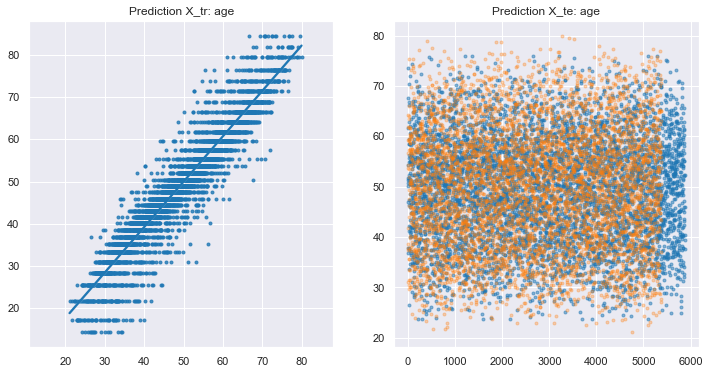

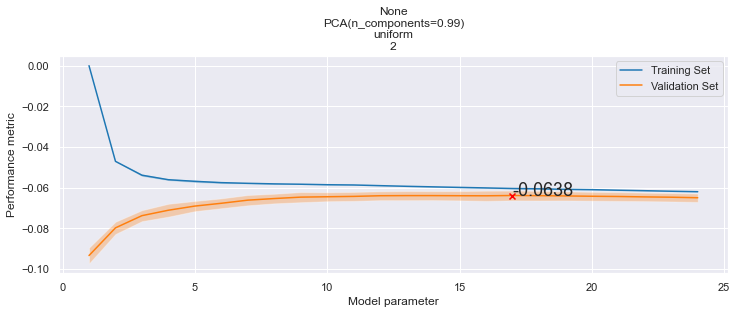

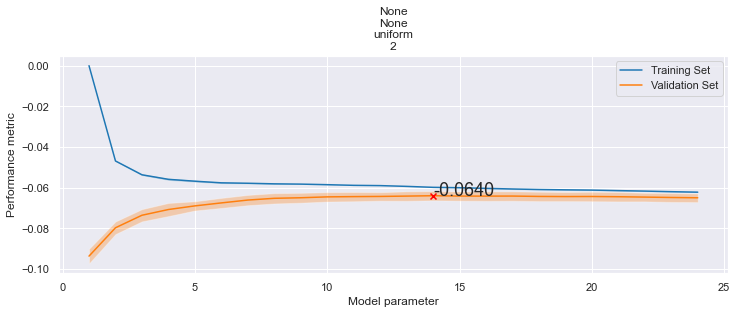

,param_estimator__n_neighbors,param_estimator__p,param_estimator__weights,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
33,17,2,uniform,PCA(n_components=0.99),None,-0.063806,0.002398,-0.060370,0.000277
25,13,2,uniform,PCA(n_components=0.99),None,-0.063859,0.002231,-0.059283,0.000181
27,14,2,uniform,PCA(n_components=0.99),None,-0.063862,0.002197,-0.059557,0.000241
35,18,2,uniform,PCA(n_components=0.99),None,-0.063895,0.002366,-0.060517,0.000285
29,15,2,uniform,PCA(n_components=0.99),None,-0.063918,0.002279,-0.059822,0.000235
23,12,2,uniform,PCA(n_components=0.99),None,-0.063920,0.002162,-0.058965,0.000192
31,16,2,uniform,PCA(n_components=0.99),None,-0.063950,0.002489,-0.060080,0.000266
26,14,2,uniform,None,None,-0.063965,0.002277,-0.059836,0.000121
37,19,2,uniform,PCA(n_components=0.99),None,-0.064021,0.002210,-0.060777,0.000317
32,17,2,uniform,None,None,-0.064135,0.002301,-0.060656,0.000297


Starting with target: domain1_var1
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


Best: -0.089602 using {'estimator__n_neighbors': 15, 'estimator__p': 2, 'estimator__weights': 'uniform', 'pca': None, 'scaler': None}


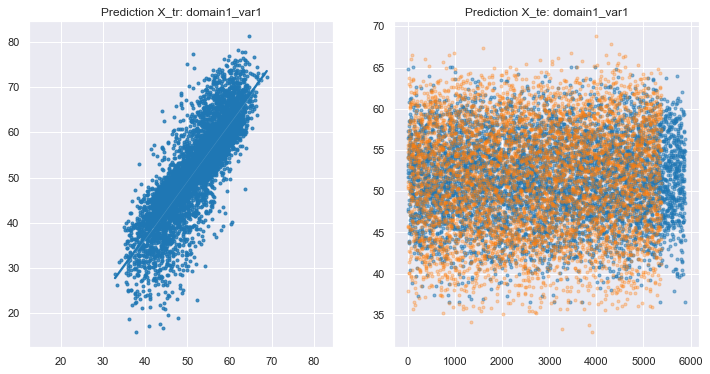

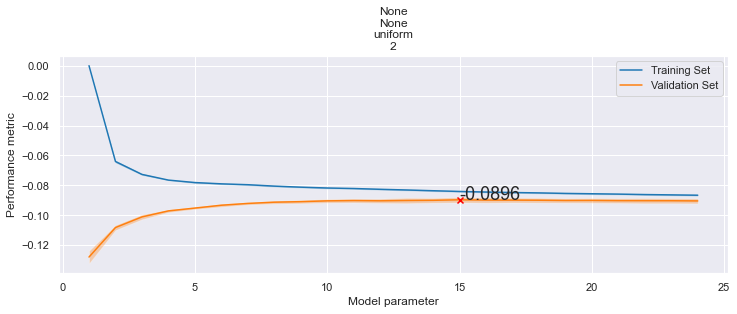

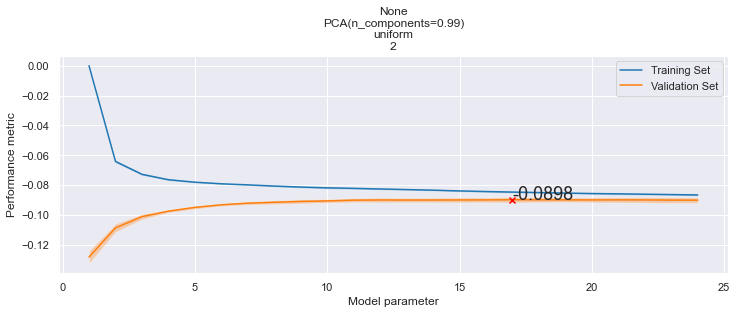

,param_estimator__n_neighbors,param_estimator__p,param_estimator__weights,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
28,15,2,uniform,None,None,-0.089602,0.001778,-0.084034,0.000585
33,17,2,uniform,PCA(n_components=0.99),None,-0.089758,0.001797,-0.084611,0.000624
35,18,2,uniform,PCA(n_components=0.99),None,-0.089792,0.001603,-0.084911,0.000633
30,16,2,uniform,None,None,-0.089805,0.001724,-0.084424,0.000579
32,17,2,uniform,None,None,-0.089822,0.001575,-0.084746,0.000560
41,21,2,uniform,PCA(n_components=0.99),None,-0.089826,0.001734,-0.085784,0.000674
37,19,2,uniform,PCA(n_components=0.99),None,-0.089831,0.001524,-0.085283,0.000561
31,16,2,uniform,PCA(n_components=0.99),None,-0.089871,0.001603,-0.084241,0.000576
43,22,2,uniform,PCA(n_components=0.99),None,-0.089877,0.001814,-0.086033,0.000640
39,20,2,uniform,PCA(n_components=0.99),None,-0.089886,0.001627,-0.085582,0.000593


Starting with target: domain1_var2
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


Best: -0.095163 using {'estimator__n_neighbors': 15, 'estimator__p': 2, 'estimator__weights': 'uniform', 'pca': PCA(n_components=0.99), 'scaler': None}


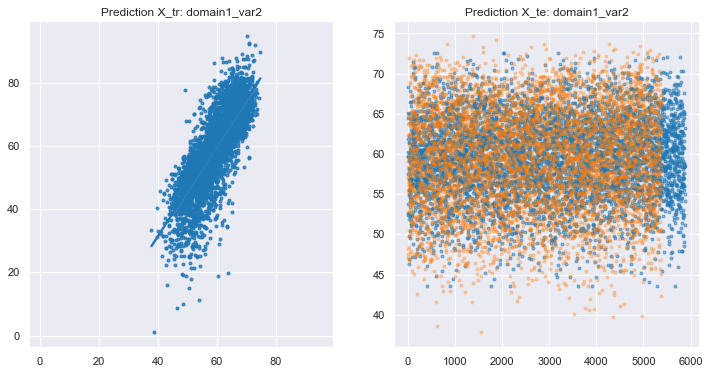

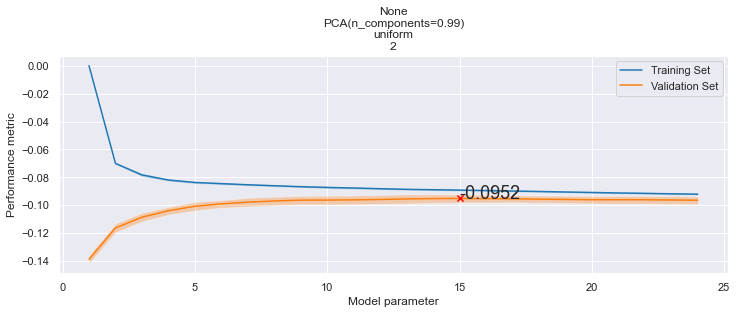

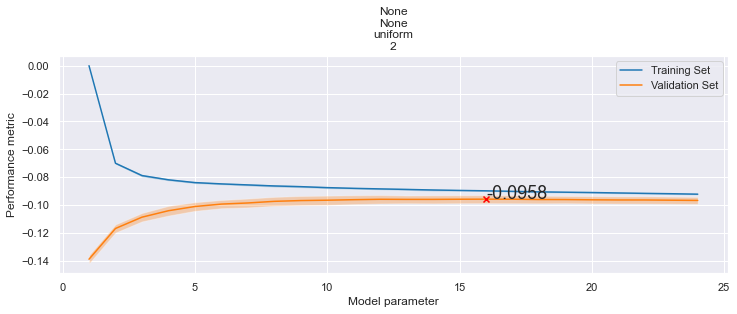

,param_estimator__n_neighbors,param_estimator__p,param_estimator__weights,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
29,15,2,uniform,PCA(n_components=0.99),None,-0.095163,0.002895,-0.089173,0.000643
27,14,2,uniform,PCA(n_components=0.99),None,-0.095259,0.003053,-0.088897,0.000619
31,16,2,uniform,PCA(n_components=0.99),None,-0.095327,0.002663,-0.089474,0.000655
33,17,2,uniform,PCA(n_components=0.99),None,-0.095408,0.002505,-0.089834,0.000677
25,13,2,uniform,PCA(n_components=0.99),None,-0.095514,0.003272,-0.088602,0.000667
35,18,2,uniform,PCA(n_components=0.99),None,-0.095672,0.002525,-0.090150,0.000617
30,16,2,uniform,None,None,-0.095775,0.002874,-0.089773,0.000540
32,17,2,uniform,None,None,-0.095800,0.002899,-0.090151,0.000605
28,15,2,uniform,None,None,-0.095828,0.002847,-0.089493,0.000592
37,19,2,uniform,PCA(n_components=0.99),None,-0.095835,0.002629,-0.090531,0.000635


Starting with target: domain2_var1
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


Best: -0.116168 using {'estimator__n_neighbors': 13, 'estimator__p': 2, 'estimator__weights': 'uniform', 'pca': PCA(n_components=0.99), 'scaler': None}


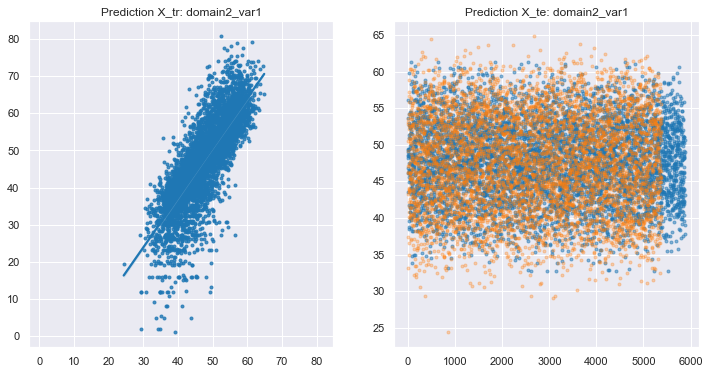

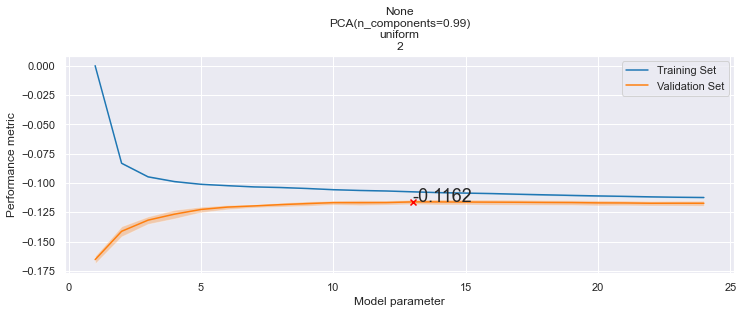

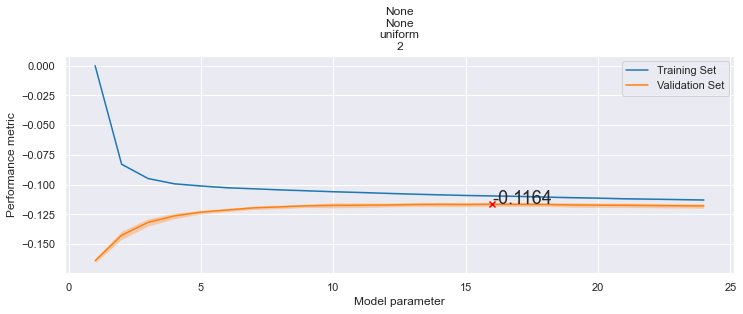

,param_estimator__n_neighbors,param_estimator__p,param_estimator__weights,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
25,13,2,uniform,PCA(n_components=0.99),None,-0.116168,0.001871,-0.107569,0.000357
27,14,2,uniform,PCA(n_components=0.99),None,-0.116195,0.002202,-0.108277,0.000341
29,15,2,uniform,PCA(n_components=0.99),None,-0.116298,0.002048,-0.108660,0.000421
31,16,2,uniform,PCA(n_components=0.99),None,-0.116400,0.002144,-0.109066,0.000439
30,16,2,uniform,None,None,-0.116446,0.001878,-0.109396,0.000444
33,17,2,uniform,PCA(n_components=0.99),None,-0.116491,0.002140,-0.109638,0.000585
32,17,2,uniform,None,None,-0.116511,0.001906,-0.109762,0.000570
26,14,2,uniform,None,None,-0.116522,0.002103,-0.108470,0.000376
34,18,2,uniform,None,None,-0.116606,0.001736,-0.110359,0.000600
28,15,2,uniform,None,None,-0.116609,0.002071,-0.108993,0.000486


Starting with target: domain2_var2
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


Best: -0.112758 using {'estimator__n_neighbors': 16, 'estimator__p': 2, 'estimator__weights': 'uniform', 'pca': None, 'scaler': None}


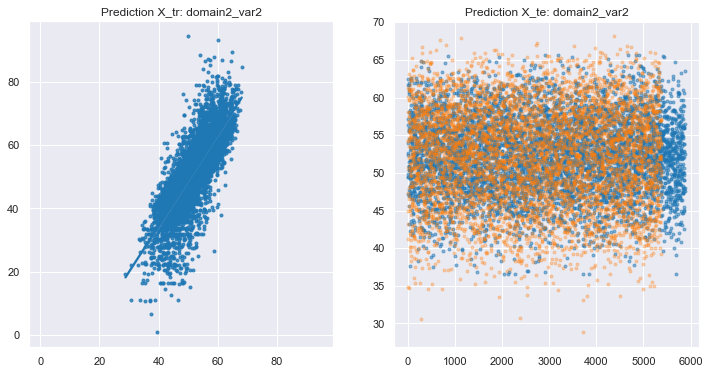

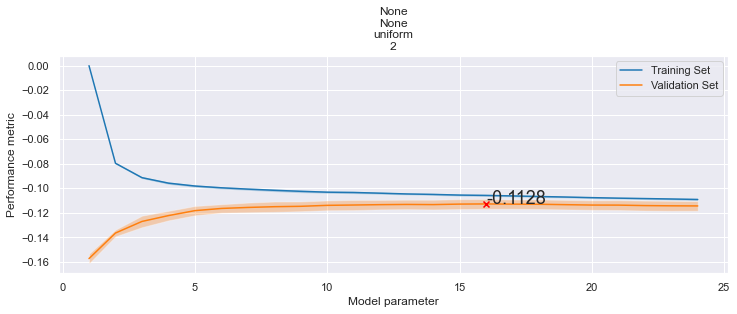

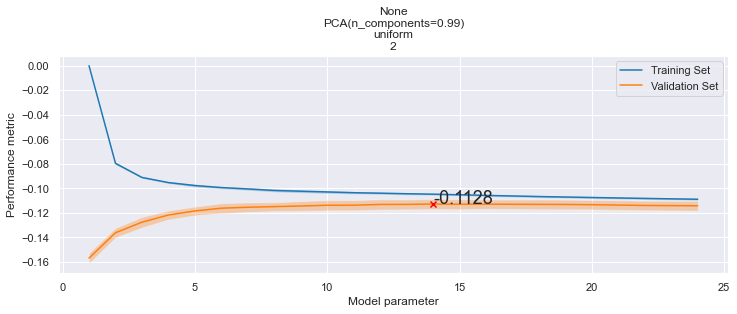

,param_estimator__n_neighbors,param_estimator__p,param_estimator__weights,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
30,16,2,uniform,None,None,-0.112758,0.003987,-0.105801,0.000854
27,14,2,uniform,PCA(n_components=0.99),None,-0.112806,0.004115,-0.104784,0.000866
28,15,2,uniform,None,None,-0.112903,0.004015,-0.105537,0.000926
32,17,2,uniform,None,None,-0.112917,0.003743,-0.106223,0.000877
31,16,2,uniform,PCA(n_components=0.99),None,-0.112934,0.003812,-0.105769,0.000835
29,15,2,uniform,PCA(n_components=0.99),None,-0.113002,0.004056,-0.105259,0.000851
33,17,2,uniform,PCA(n_components=0.99),None,-0.113018,0.003838,-0.106240,0.000839
34,18,2,uniform,None,None,-0.113028,0.003871,-0.106695,0.000878
35,18,2,uniform,PCA(n_components=0.99),None,-0.113105,0.003978,-0.106699,0.000921
25,13,2,uniform,PCA(n_components=0.99),None,-0.113129,0.004014,-0.104413,0.000929


,score,estimator__n_neighbors,estimator__p,estimator__weights,pca,scaler
0,0.063806,17,2,uniform,PCA(n_components=0.99),None
1,0.089602,15,2,uniform,None,None
2,0.095163,15,2,uniform,PCA(n_components=0.99),None
3,0.116168,13,2,uniform,PCA(n_components=0.99),None
4,0.112758,16,2,uniform,None,None


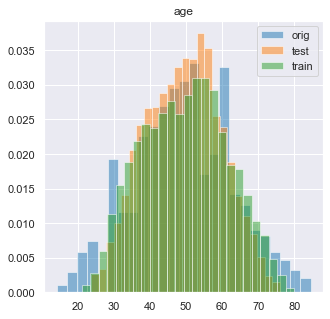

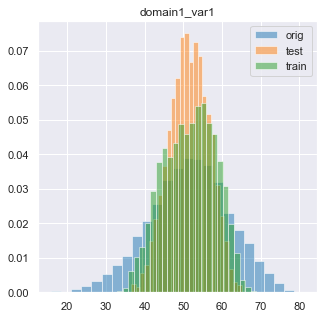

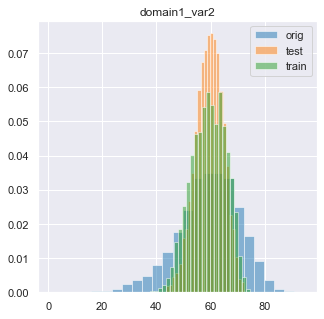

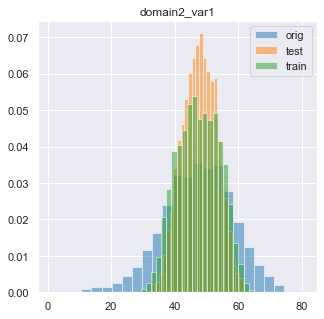

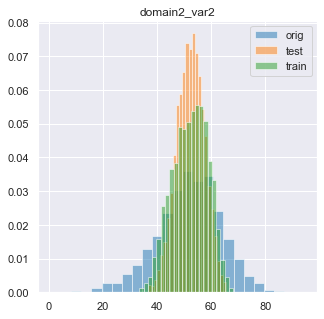

Score: 0.0915 | -0.0638 -0.0896 -0.0952 -0.1162 -0.1128


In [25]:
dataset_id = 'knn'

predictions = {}
scores = []
grids = []

for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

    print('Starting with target: %s' % (target))
    estimator = KNeighborsRegressor()
    df_pred, pred_tr, pred_te, grid, idx = run_prediction(
        model_metric, target=target, estimator=estimator, tidx=tidx)

    display_grid_optimization_details(grid)

    predictions['%s_tr' % target] = pred_tr
    predictions['%s_te' % target] = pred_te
    predictions['%s_miss' % target] = idx

    scores.append(grid.best_score_)
    grids.append(grid)

# Display grids summary
grids_summary(grids)

# Compute overall score
weights = [.3, .175, .175, .175, .175]
score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

df_results_tr, df_results_te = save_results(
    predictions, targets, train_id, test_id, sample_submission, dataset_id, score_postfix)

_, _, y_tr, _ = load_dataset()
df_target = pd.DataFrame(y_tr, columns=targets.columns)
plot_prediction_distributions(df_target, df_results_tr, df_results_te)

# Feedback of overall score
txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
print(txt)